In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "9g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()

24/10/02 00:50:17 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 192.168.0.52 instead (on interface en0)
24/10/02 00:50:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 00:50:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/02 00:50:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
transactions1 = spark.read.parquet("../data/transactions/transactions_20210228_20210827_snapshot")
transactions2 = spark.read.parquet("../data/transactions/transactions_20210828_20220227_snapshot")
transactions3 = spark.read.parquet("../data/transactions/transactions_20220228_20220828_snapshot")

transactions = transactions1.union(transactions2).union(transactions3)

transactions = transactions.withColumn('user_id', F.col('user_id').cast(StringType()))
transactions = transactions.withColumn('merchant_abn', F.col('merchant_abn').cast(StringType()))

transactions.show(truncate=False)

+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |
|18479  |67609108741 |86.4040605836911  |d0e180f0-cb06-42a3-bd1a-c47dca15bc55|2021-08-20    |
|3      |34096466752 |301.5793450525113 |6fb1ff48-24bb-4f97-

In [3]:
consumer_fraud = spark.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud = consumer_fraud.withColumn('order_datetime', F.col('order_datetime').cast(DateType()))
consumer_fraud = consumer_fraud.withColumn('fraud_probability', F.col('fraud_probability').cast('double'))

consumer_details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
consumer_details = consumer_details.withColumn('user_id', F.col('user_id').cast('string'))
consumer_details = consumer_details.withColumn('consumer_id', F.col('consumer_id').cast('string'))

merchant_fraud = spark.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud = merchant_fraud.withColumnRenamed('fraud_probability', 'merchant_fraud_probability')
merchant_fraud = merchant_fraud.withColumn('merchant_fraud_probability', F.col('merchant_fraud_probability').cast('double'))

tbl_consumer = spark.read.option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")

tbl_consumer = tbl_consumer.filter(F.col("state").isin(["NSW", "WA", "NT", "VIC", "TAS", "QLD", "SA",   "ACT"]))
tbl_consumer = tbl_consumer.filter(F.col("gender").isin(["Female", "Male", "Undisclosed"]))
tbl_consumer = tbl_consumer.withColumn("postcode", tbl_consumer["postcode"].cast(IntegerType()))
tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer_name")

In [4]:
tbl_merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")
tbl_merchants = tbl_merchants.withColumn('tags', F.regexp_replace('tags', r'\(', r'\[')) \
    .withColumn('tags', F.lower(F.regexp_replace('tags', r'\)', r'\]')))

tbl_merchants = tbl_merchants.withColumn('tags1', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=1)))
tbl_merchants = tbl_merchants.withColumn('tags2', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=2)))
tbl_merchants = tbl_merchants.withColumn('tags3', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=3)).cast(DoubleType()))

tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants = tbl_merchants.withColumnRenamed('tags3', 'take_rate')
tbl_merchants = tbl_merchants.withColumnRenamed('tags2', 'type')
tbl_merchants = tbl_merchants.withColumnRenamed("name", "merchant_name")
tbl_merchants = tbl_merchants.drop('tags')
tbl_merchants = tbl_merchants.withColumnRenamed('tags1', 'tags')

tbl_merchants.show(truncate=False)

+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|merchant_name                       |merchant_abn|tags                                                            |type|take_rate|
+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|Felis Limited                       |10023283211 |furniture, home furnishings, equipment, manufacturers           |e   |0.18     |
|Arcu Ac Orci Corporation            |10142254217 |cable, satellite, other pay television, radio                   |b   |4.22     |
|Nunc Sed Company                    |10165489824 |jewelry, watch, clock, silverware                               |b   |4.4      |
|Ultricies Dignissim Lacus Foundation|10187291046 |watch, clock, jewelry repair                                    |b   |3.29     |
|Enim Condimentum PC                 |10192359162 |music, musical instrument

In [5]:
full_transactions = transactions.join(consumer_details, on="user_id",how="left") \
                   .join(tbl_consumer, on="consumer_id",how="left") \
                   .join(consumer_fraud, on=["user_id", "order_datetime"],how="left") \
                   .join(tbl_merchants, on="merchant_abn",how="left") \
                   .join(merchant_fraud, on=["order_datetime", "merchant_abn"], how="left")

full_transactions.show(truncate=False)

+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|dollar_value       |order_id                            |consumer_name  |address                   |state|postcode|gender|fraud_probability|merchant_name                    |tags                                                            |type|take_rate|merchant_fraud_probability|
+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|2022-0

In [6]:
print(full_transactions.where(F.col("merchant_name").isNull()).count(), full_transactions.count())
full_transactions = full_transactions.where(F.col("merchant_name").isNotNull())
print(full_transactions.where(F.col("merchant_name").isNull()).count(), full_transactions.count())

580863 14195717


0 13614854


In [7]:
postcodes = gpd.read_file("../data/landing/POA_2021_AUST_GDA2020_SHP")
postcodes = postcodes.to_crs(epsg='4326')

postcodes['lon'] = postcodes.geometry.centroid.x
postcodes['lat'] = postcodes.geometry.centroid.y
postcodes = postcodes.drop(columns='geometry')
postcodes = postcodes.loc[:, ['POA_CODE21', 'AREASQKM21', 'SHAPE_Leng', 'SHAPE_Area', 'lon', 'lat']]
postcodes = postcodes.rename(columns={'POA_CODE21': 'postcode'})

postcodes = spark.createDataFrame(postcodes)

full_transactions = full_transactions.join(postcodes, on='postcode')
full_transactions.show(truncate=False)

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_85583/3306163271.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lon'] = postcodes.geometry.centroid.x
/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_85583/3306163271.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lat'] = postcodes.geometry.centroid.y


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |
+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------

In [8]:
# Combine the census data into a single dataframe, by postcode
# https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=SA2&header=S
TABLES = [
    '2021Census_G02_AUST_POA.csv',
    '2021Census_G04A_AUST_POA.csv',
    '2021Census_G04B_AUST_POA.csv'
]
POSTCODE_COLUMN = 'POA_CODE_2021'
SELECTED_COLUMNS = [
    POSTCODE_COLUMN,
    'Median_age_persons', 
    'Median_tot_fam_inc_weekly', 
    'Median_tot_hhd_inc_weekly', 
    'Average_household_size', 
    'Tot_M', 
    'Tot_P', 
    'Tot_F'
]

census_df = None
for table in TABLES:
    df = spark.read.options(header=True) \
        .csv(f"../data/landing/2021_GCP_POA_for_AUS_short-header/2021 Census GCP Postal Areas for AUS/{table}")

    if census_df is None:
        census_df = df
    else:
        census_df = census_df.join(df, POSTCODE_COLUMN).drop(df[POSTCODE_COLUMN])

census_df = census_df.withColumn(POSTCODE_COLUMN, F.regexp_replace(F.col(POSTCODE_COLUMN), "(\D)", ""))
census_df = census_df.select(*SELECTED_COLUMNS)
for column in SELECTED_COLUMNS[1:]:
    census_df = census_df.withColumn(column, F.col(column).cast(DoubleType()))
census_df = census_df.withColumnRenamed("POA_CODE_2021", "postcode")
census_df.show(truncate=False)

full_transactions = full_transactions.join(census_df, on='postcode', how="left")
full_transactions.show(truncate=False)

# census_df.summary().show()
# census_df.write.mode('overwrite').parquet('../data/raw/census2021.parquet')

+--------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|postcode|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M  |Tot_P  |Tot_F  |
+--------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|2000    |32.0              |2367.0                   |2225.0                   |2.1                   |14223.0|27936.0|13713.0|
|2007    |30.0              |2197.0                   |1805.0                   |2.1                   |3763.0 |7410.0 |3644.0 |
|2008    |28.0              |2453.0                   |1746.0                   |1.9                   |5315.0 |10400.0|5083.0 |
|2009    |37.0              |3035.0                   |2422.0                   |2.1                   |6391.0 |12658.0|6267.0 |
|2010    |36.0              |3709.0                   |2297.0                   |1.7             

24/10/02 00:41:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size

In [9]:
retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
retail_df.show(truncate=False)

full_transactions = full_transactions.withColumn("month", F.month("order_datetime"))
full_transactions = full_transactions.withColumn("year", F.year("order_datetime"))
full_transactions = full_transactions.join(retail_df, on=['month', 'year'], how='left')
full_transactions.show(truncate=False)

+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|NSW_original|VIC_original|QLD_original|SA_original|WA_original|TAS_original|NT_original|ACT_original|Total_original|NSW_seasonal|VIC_seasonal|QLD_seasonal|SA_seasonal|WA_seasonal|TAS_seasonal|NT_seasonal|ACT_seasonal|Total_seasonal|month|year|
+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|1234.2      |887.0       |494.1       |277.2      |301.5      |77.5        |NULL       |55.3        |3357.8        |1309.8      |952.9       |518.6       |288.9      |321.2      |81.0        |NULL       |58.3        |3561.5        |6    |1982|
|1265.0      |921.3 

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                     

[29.55524469 69.74088753 28.34260128 28.61547889 28.69020429 28.35387345
 30.57903216 29.05714322 29.53973321 28.50447905 30.23903245 27.93103068
 59.77648897 28.34828039 66.52282263 30.57903216 28.50447905 28.34140136
 29.16784078 29.55524469 30.02429183 28.8067089  28.35274652 28.50447905
 33.01471361 28.79521209 30.57903216 28.3373702  28.39941282 31.34350232
 28.50447905 31.34350232 28.3373702  30.57903216 29.75107524 28.78568573
 30.57903216 28.45905354 28.69020429 56.43761255 29.53973321 29.53973321
 29.08815812 30.02429183 29.85552419 29.55524469 30.57903216 28.65161761
 28.2815079  30.57903216 29.10401486 28.53232082 29.55524469 30.57903216
 30.23841986 28.20537898 29.53947304 32.49943591 30.57903216 28.50447905
 28.69020429 29.27259775 28.24267057 30.02429183 30.02429183 29.0263052
 29.05393297 28.8367477  31.48391056 28.34721657 28.50447905 30.57903216
 30.09158408 29.52661883 28.35898078 63.37734365 30.57903216 28.61661768
 30.57903216 28.95733256 28.10085623 31.02465578 28.

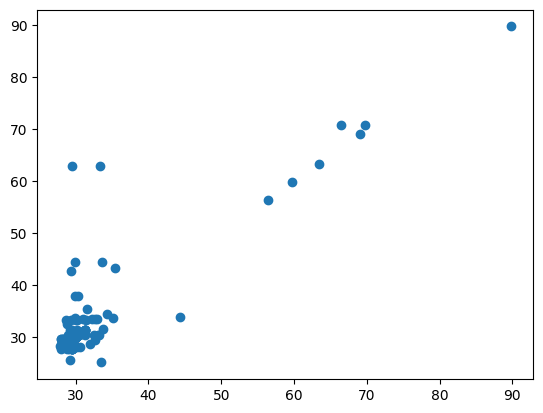

In [108]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

transactions = spark.read.parquet("../data/curated/transactions.parquet")

transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()

X = transactions.drop('merchant_fraud_probability', axis=1)
y = transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test)
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [115]:
pipeline.fit(X, y)
transactions = pd.read_parquet("../data/curated/transactions.parquet")

mask = transactions['merchant_fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('merchant_fraud_probability', axis=1)

transactions.loc[mask, 'merchant_fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions1.parquet")

24/10/02 00:50:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


RMSE: 8.309688347172422


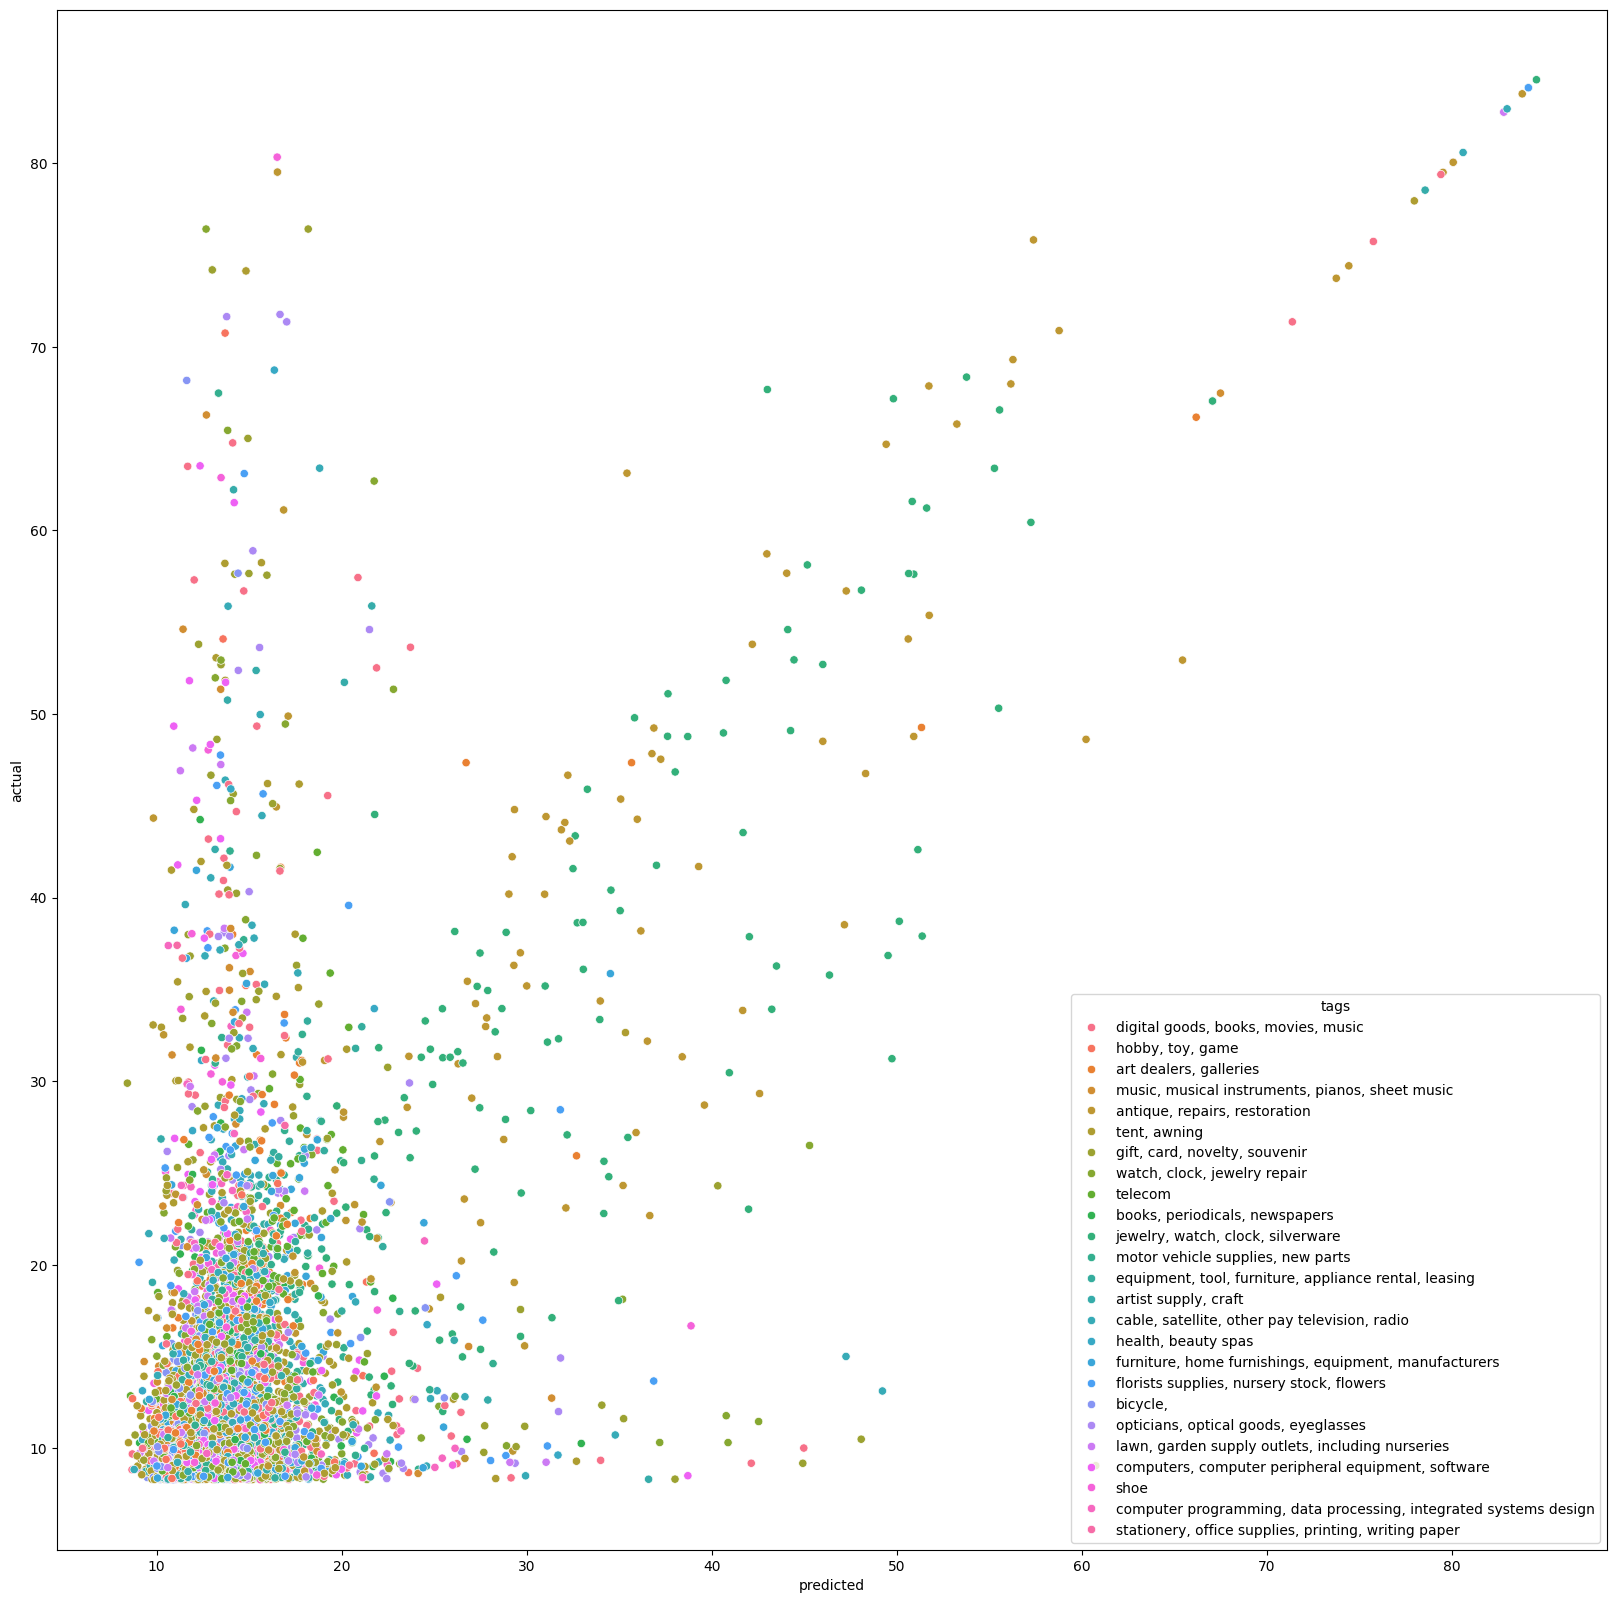

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

transactions = spark.read.parquet("../data/curated/transactions1.parquet")

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=int(math.sqrt(len(transactions)) / 2), weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

combined = X_test
combined['predicted'] = pipeline.predict(X_test)
combined['actual'] = y_test
plt.figure(figsize=(20, 20))
sns.scatterplot(combined, x='predicted', y='actual', hue='tags')

print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [12]:
# pipeline.fit(X, y)
# print("Fitted pipeline")
# transactions = pd.read_parquet("../data/curated/transactions1.parquet")

# mask = transactions['fraud_probability'].isna()

# transactions_to_predict = transactions.loc[mask, :]
# X_to_predict = transactions_to_predict.drop('fraud_probability', axis=1)

# transactions.loc[mask, 'fraud_probability'] = pipeline.predict(X_to_predict)
# transactions.to_parquet("../data/curated/transactions2.parquet")

In [6]:
pipeline.fit(X, y)
print("Fitted pipeline")

transactions = pd.read_parquet("../data/curated/transactions1.parquet")

mask = transactions['fraud_probability'].isna()
transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('fraud_probability', axis=1)

batch_size = 50000
predictions = []

print(len(X_to_predict))
i = 0
for start in range(0, X_to_predict.shape[0], batch_size):
    end = min(start + batch_size, X_to_predict.shape[0])
    batch = X_to_predict.iloc[start:end]
    preds = pipeline.predict(batch)
    predictions.extend(preds)
    print(f"Finished batch {i}")
    i += 1

transactions.loc[mask, 'fraud_probability'] = predictions

transactions.to_parquet("../data/curated/transactions2.parquet")

Fitted pipeline
11310708
Finished batch 0


In [107]:
full_transactions.write.mode("overwrite").parquet("../data/curated/transactions.parquet")

In [81]:
full_transactions.show()

+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+-------------+---------------+-----+------+-----------------+--------------------+--------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|consumer_name|        address|state|gender|fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|   SHAPE_Leng|    SHAPE_Area|               lon|         